In [1]:
import pandas
import numpy as np
import cv2
import matplotlib.pyplot as plt

# read the csv file
df = pandas.read_csv('081624_roi_metadata_mod.csv')
df_oriented =  pandas.read_csv('081624_roi_metadata_oriented.csv')
df.head()

rois = []

# sort the df rows by the 'strip' column, so that the strips are in order
# Thse are numeric, so treat them as such
df['strip'] = df['strip'].astype(int)
df = df.sort_values('strip')

# iterate through the rows of the datafare
for i, row in df.iterrows():
    
    image = cv2.imread(row['filename'])
    
    # use the x and y coordinates to draw a rectangle around the ROI
    box_size = row['box_size'] * 2
    x = int(row['x'] - box_size / 2)
    y = int(row['y'] - box_size / 2)
    slice_x1, slice_y1, slice_x2, slice_y2 = row['x1'], row['y1'], row['x2'], row['y2']

    # if any of the x, y, slice_x1, slice_y1, slice_x2, slice_y2 are negative, skip this row
    if x < 0 or y < 0 or slice_x1 < 0 or slice_y1 < 0 or slice_x2 < 0 or slice_y2 < 0:
        continue

    # crop the image to the ROI
    roi = image[y:y+box_size, x:x+box_size]

    # rotate the image by the rotation angle
    rotation_matrix = cv2.getRotationMatrix2D((box_size/2, box_size/2), row['rotation_angle'], 1)
    roi = cv2.warpAffine(roi, rotation_matrix, (box_size, box_size))

    # crop back to the original size
    roi = roi[int(box_size/4):int(box_size*3/4), int(box_size/4):int(box_size*3/4)]

    # draw the rectangle on the roi
    cv2.rectangle(roi, (slice_x1, slice_y1), (slice_x2, slice_y2), (0, 255, 0), 2)

    # draw the rectangle of the oriented roi from the oriented dataframe
    oriented_row = df_oriented.loc[df_oriented['strip'] == row['strip']]

    cv2.rectangle(roi, (oriented_row['x1'].values[0], oriented_row['y1'].values[0]), (oriented_row['x2'].values[0], oriented_row['y2'].values[0]), (0, 0, 255), 2)
    

    # add the i and the label to the image
    cv2.putText(roi, f'{row["strip"]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # add the images to the roi list
    rois.append(roi)


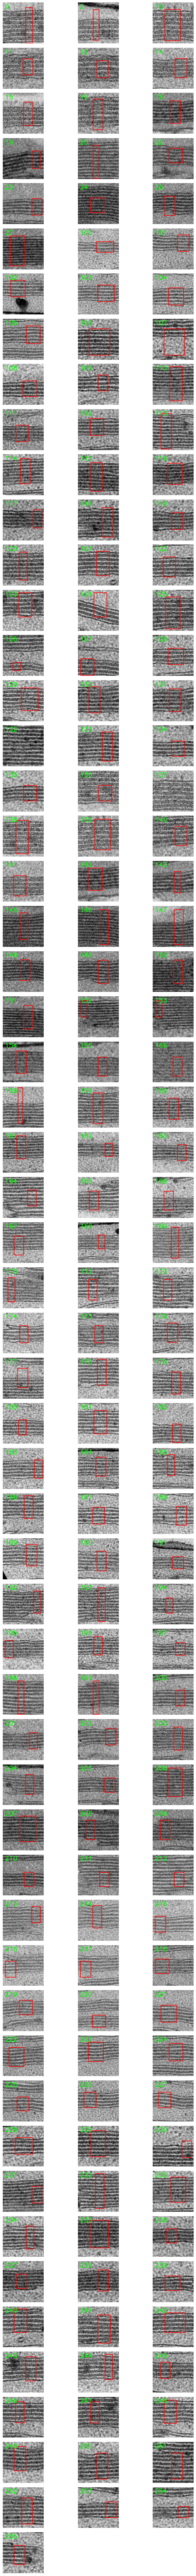

In [2]:
# num images per row
n_images_per_row = 3

# Increase the figsize to make the images larger
plt.figure(figsize=(8, 90)) 

# figure out how many rows we need, with 5 images per row
n_rows = len(rois) // n_images_per_row

# if there are any remaining images, add an extra row
if len(rois) % n_images_per_row != 0:
    n_rows += 1
    
# the images are too small! Lets make sure the image is larger
for i, roi in enumerate(rois):
    plt.subplot(n_rows, n_images_per_row, i+1)
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.tight_layout()

# Adjust the layout to have more space around images
# plt.subplots_adjust(wspace=-0.85, hspace=0.2)
plt.savefig('oriented_rois.png')